In [300]:
library(tidyverse)

# Here we train our final model using the parameters from before.
setwd("/home/joosungm/projects/def-lelliott/joosungm/projects/peak-bloom-prediction/code/")
# best_params <- read.csv("../outputs/B_outputs/B11_lgb_grid_kyoto_best_params.csv")
best_params


boostings,learning_rates,max_bins,num_leaves,max_depth,iteration,binary_logloss,auc,binary_error
<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
gbdt,0.1,125,10,20,47,0.300,0.932,0.125
gbdt,0.1,125,20,-1,19,0.324,0.934,0.129
gbdt,0.1,25,15,20,22,0.319,0.928,0.123


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 160  35
         1  32  78
                                          
               Accuracy : 0.7803          
                 95% CI : (0.7296, 0.8255)
    No Information Rate : 0.6295          
    P-Value [Acc > NIR] : 1.06e-08        
                                          
                  Kappa : 0.5265          
                                          
 Mcnemar's Test P-Value : 0.807           
                                          
            Sensitivity : 0.8333          
            Specificity : 0.6903          
         Pos Pred Value : 0.8205          
         Neg Pred Value : 0.7091          
             Prevalence : 0.6295          
         Detection Rate : 0.5246          
   Detection Prevalence : 0.6393          
      Balanced Accuracy : 0.7618          
                                          
       'Positive' Class : 0               
                              

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
Ca_cumsum,0.501163686,0.48076914,0.35714286
day,0.334898463,0.22892351,0.23511905
month,0.079195878,0.10302512,0.11160714
Cd_cumsum,0.036789459,0.07510455,0.14136905
lat,0.022924615,0.06320738,0.06250000
alt,0.015318374,0.04087837,0.05505952
long,0.009709525,0.00809194,0.03720238


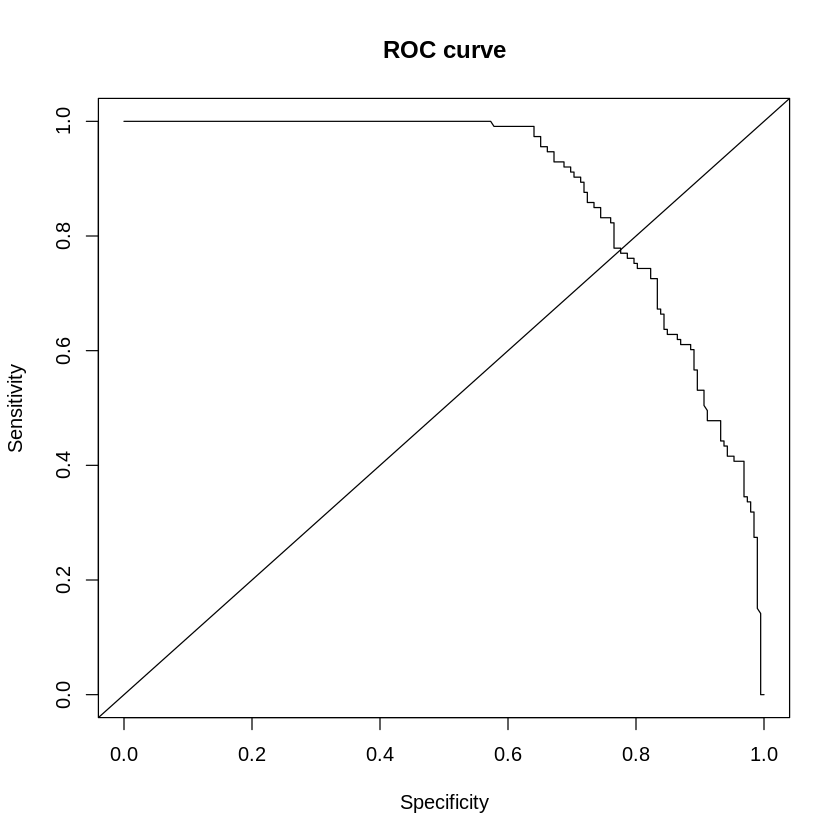

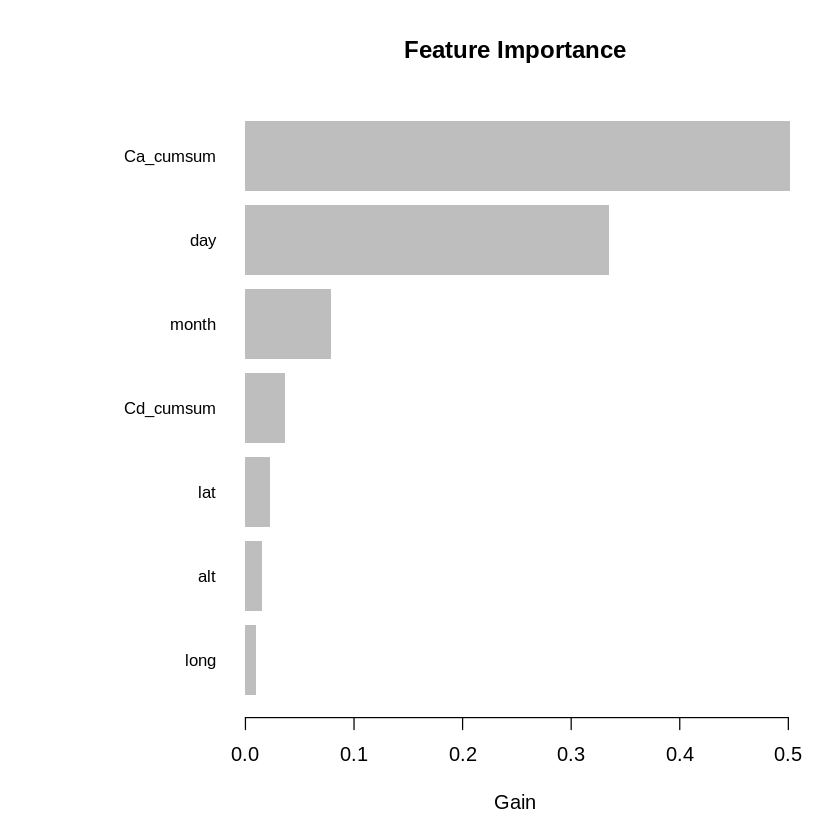

In [320]:
# Run below codes after running the above
library(tidyverse)
library(lightgbm)

lgb_load <- readRDS.lgb.Booster('../outputs/B_outputs/B21_lgb_final.rds')
test_set <- read.csv("../outputs/B_outputs/B11_japan_test.csv")
source("/home/joosungm/projects/def-lelliott/joosungm/projects/peak-bloom-prediction/code/F01_functions.r")
# feature_names <- c("tmax", "tmin", "prcp", "month", "day", "daily_Ca", "daily_Cd", "Cd_cumsum", "Ca_cumsum", "lat", "long", "alt")
# target_col <- "is_bloom"

pred <- predict(lgb_load, as.matrix(test_set[, feature_names]))
test_set$predicted <- ifelse(pred > 0.7, 1, 0)

# Confusion matrix
library(caret)
confusionMatrix(factor(test_set$predicted), factor(test_set$is_bloom))

# ROC curve
library(ROCR)
roc_pred <- prediction(pred, test_set$is_bloom)
roc <- performance(roc_pred, "sens", "spec")
plot(roc, main="ROC curve")
abline(a=0, b=1)

# Feature importance
lgb_imp <- lgb.importance(lgb_load)
lgb_imp
lgb.plot.importance(lgb_imp, top_n = 10L, measure = "Gain")

In [303]:
cherry_main_data <- read.csv("../outputs/A_outputs/A11_kyoto_out.csv") %>%
    filter(year %in% 2012:2023) %>%
    dplyr::select(all_of(c("bloom_date", "lat", "long", "alt")))
# head(cherry_main_data)

gdd_data <- read.csv("../outputs/A_outputs/A41_gdd_kyoto.csv") %>%
    filter(year %in% 2012:2023) %>%
    filter(name == "KYOTO") %>%
    mutate(lat = unique(cherry_main_data$lat)) %>%
    mutate(long = unique(cherry_main_data$long)) %>%
    mutate(alt = unique(cherry_main_data$alt))
head(gdd_data)
dim(gdd_data)

write.csv("../outputs/B_outputs/B21_kyoto_gdd_test.csv", row.names = FALSE)


,name,date,id,tmax,tmin,prcp,year,month,day,row_num,⋯,daily_Ca,Cd_cumsum,Ca_cumsum,diff_Ca_Cd,diff_Ca_Cd_cumsum,lat,long,alt,bloom_doy,is_bloom
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,KYOTO,2012-03-01,JA000047759,16.3,2.9,0.0,2012,3,1,21946,⋯,4.65,-249.8768,29.35,2.600000,443.4732,35.01198,135.6761,44,NA,0
2,KYOTO,2012-03-02,JA000047759,10.6,-1.5,5.1,2012,3,2,21947,⋯,1.80,-252.7197,31.15,-1.042975,442.4303,35.01198,135.6761,44,NA,0
3,KYOTO,2012-03-03,JA000047759,13.4,1.2,6.1,2012,3,3,21948,⋯,3.20,-255.6197,34.35,0.300000,442.7303,35.01198,135.6761,44,NA,0
4,KYOTO,2012-03-04,JA000047759,15.0,2.7,0.0,2012,3,4,21949,⋯,4.00,-257.7697,38.35,1.850000,444.5803,35.01198,135.6761,44,NA,0
5,KYOTO,2012-03-05,JA000047759,12.9,8.7,34.0,2012,3,5,21950,⋯,3.80,-257.7697,42.15,3.800000,448.3803,35.01198,135.6761,44,NA,0
6,KYOTO,2012-03-06,JA000047759,10.2,2.6,21.6,2012,3,6,21951,⋯,1.60,-259.9697,43.75,-0.600000,447.7803,35.01198,135.6761,44,NA,0


[1] 502  22

"x"
"../outputs/B_outputs/B21_kyoto_gdd_test.csv"


In [315]:
# Make predictions
kyoto_gdd <- gdd_data
kyoto_years <- unique(kyoto_gdd$year)
error_cols <- c("year", "date", "pred_date", "diff")
error_table <- data.frame(matrix(nrow = length(kyoto_years), ncol = length(error_cols), dimnames = list(NULL, error_cols)))

p_thresh <- 0.70

for (y in seq_len(length(kyoto_years))) {
    
    yr <- kyoto_years[y]
    
    temp_data <- kyoto_gdd[kyoto_gdd$year == yr, ]
    pred <- predict(lgb_load, as.matrix(temp_data[, feature_names]))
    temp_data$pred_prob <- pred
    temp_data$pred_bin <- ifelse(pred > p_thresh, 1, 0)

    actual_bloom_idx <- which(temp_data$is_bloom == 1)
    actual_bloom_date <- temp_data[actual_bloom_idx, "date"]
    if (yr == 2022) {
        actual_bloom_date <- "2022-04-01"
    }
    
    pred_blooms <- which(temp_data$pred_bin == 1)
    pred_bloom_start_idx <- pred_blooms[1]
    # pred_bloom_start_idx <- which(temp_data$pred_prob == max(temp_data$pred_prob))[1] -3 # take the highest probability day as the blooming date.
    pred_bloom_start_date <- temp_data[pred_bloom_start_idx, "date"]
    
    if (is.na(pred_bloom_start_date)) {
        pred_bloom_start_date <- temp_data[which(temp_data$pred_prob == max(temp_data$pred_prob))[1], "date"]
    }

    temp_diff <- as.numeric(as.Date(pred_bloom_start_date)) - as.numeric(as.Date(actual_bloom_date))
    error_table[y, ] <- c(yr, actual_bloom_date, pred_bloom_start_date, temp_diff)
}
error_table
mean(abs(as.numeric(error_table$diff)), na.rm = TRUE)

year,date,pred_date,diff
<chr>,<chr>,<chr>,<chr>
2012,2012-04-09,2012-04-04,-5
2013,2013-03-30,2013-03-31,1
2014,2014-04-02,2014-03-31,-2
2015,2015-04-01,2015-03-31,-1
2016,2016-04-02,2016-03-31,-2
2017,2017-04-07,2017-04-02,-5
2018,2018-03-28,2018-03-31,3
2019,2019-04-06,2019-03-31,-6
2020,2020-03-30,2020-03-31,1


[1] 2.545455

,year,date,bloom_doy,cat
,<chr>,<chr>,<dbl>,<chr>
1,2012,2012-04-09,99,actual
2,2013,2013-03-30,88,actual
3,2014,2014-04-02,91,actual
4,2015,2015-04-01,90,actual
5,2016,2016-04-02,92,actual
6,2017,2017-04-07,96,actual


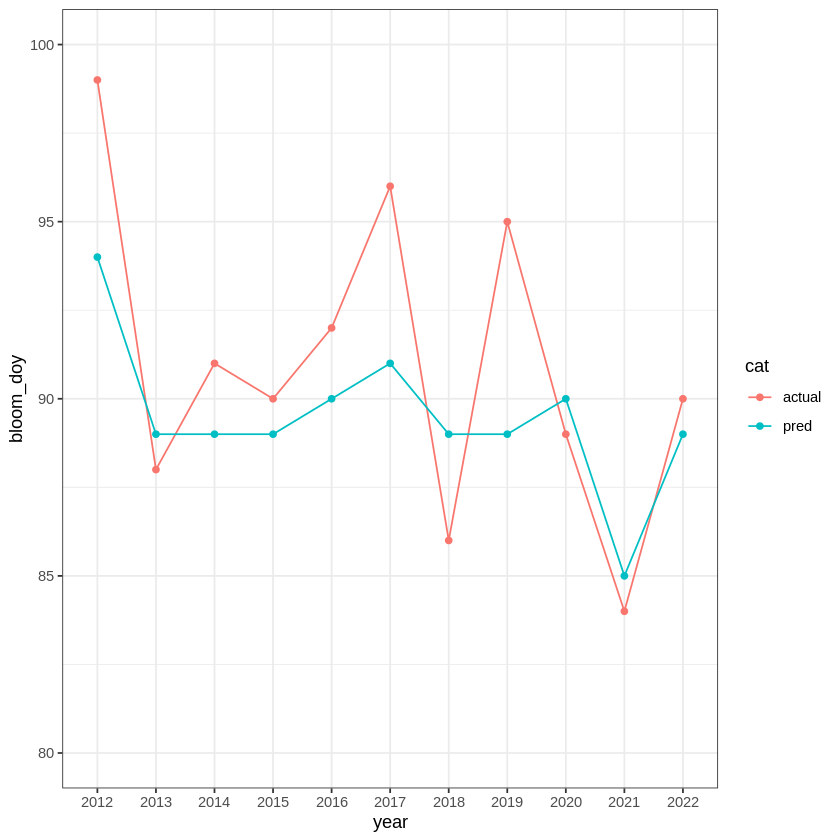

In [316]:
# plot bloom_doys

error_table2 <- error_table
error_table2$first_day <- as.Date(paste0(error_table2$year, "-01-01"))
error_table2$actual_bloom_doy <- as.numeric(as.Date(error_table2$date)) - as.numeric(as.Date(error_table2$first_day))
error_table2$pred_bloom_doy <- as.numeric(as.Date(error_table2$pred_date)) - as.numeric(as.Date(error_table2$first_day))
# head(error_table2)

error_table2_actual <- error_table2 %>% 
    select(year, date, actual_bloom_doy) %>% mutate(cat = "actual") %>% 
    rename_with(~"bloom_doy", actual_bloom_doy)

error_table2_pred <- error_table2 %>% select(year, pred_date, pred_bloom_doy) %>% mutate(cat = "pred") %>% 
    rename_with(~"bloom_doy", pred_bloom_doy) %>% 
    rename_with(~"date", pred_date)

error_table3 <- rbind(error_table2_actual, error_table2_pred)
head(error_table3)

col_groups <- c("tomato", "dark green")

p <- ggplot(data = error_table3, mapping = aes(x = year, y = bloom_doy, group = cat, color = cat))
p <- p + geom_line()
p <- p + geom_point()
p <- p + theme_bw()
p <- p + ylim(c(80, 100))
p

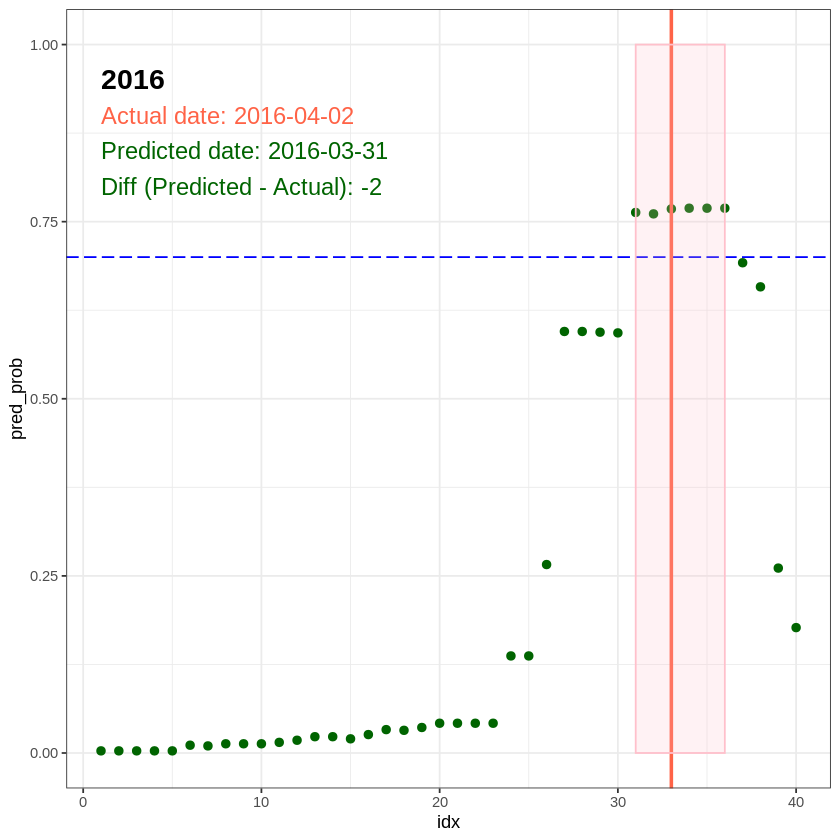

In [312]:
# for one year

yr = 2016
p_thresh <- 0.70
year_data <- gdd_data %>% filter(year == yr & name == "KYOTO") %>%
    dplyr::select(all_of(c("date", feature_names, target_col)))
# head(year_data[year_data$is_bloom == 1, ])
# dim(year_data)

# Make prediction on this data

pred <- predict(lgb_load, as.matrix(year_data[, feature_names]))
year_data$pred_prob <- round(pred, 3) 
year_data$pred_bin <- ifelse(pred > p_thresh, 1, 0)
year_data$idx <- seq_len(nrow(year_data))
# year_data[, c("date", "is_bloom", "pred_prob", "pred_bin")]

actual_bloom_day_idx <- which(year_data$is_bloom == 1)
actual_bloom_day <- year_data[actual_bloom_day_idx, "date"]

predicted_bloom_days <- which(year_data$pred_bin == 1)
predicted_bloom_day_idx <-predicted_bloom_days[1]
predicted_bloom_day <- year_data[predicted_bloom_day_idx, "date"]
predicted_bloom_end_idx <- predicted_bloom_days[length(predicted_bloom_days)]

diff_days <- as.numeric(as.Date(predicted_bloom_day)) - as.numeric(as.Date(actual_bloom_day))

p <- ggplot(data = year_data)
p <- p + geom_point(aes(x = idx, y = pred_prob), color = "dark green", lwd = 2)
p <- p + ylim(c(0, 1))
p <- p + geom_hline(yintercept = p_thresh, color = "blue", linetype = "longdash")
p <- p + geom_vline(xintercept = actual_bloom_day_idx, color = "tomato", linetype = "solid", lwd = 1)
p <- p + theme_bw()
p <- p + annotate("text", x = 1, y = 0.95, label = yr, fontface = "bold", color = "black", size = 6, hjust = 0)
p <- p + annotate("text", x = 1, y = 0.90, label = paste0("Actual date: ", actual_bloom_day), size = 5, color = "tomato", hjust = 0)
p <- p + annotate("text", x = 1, y = 0.85, label = paste0("Predicted date: ", predicted_bloom_day), size = 5, color = "dark green", hjust = 0)
p <- p + annotate("text", x = 1, y = 0.80, label = paste0("Diff (Predicted - Actual): ", diff_days), color = ifelse(diff_days > 0, "tomato", "dark green"), size = 5, hjust = 0)
p <- p + annotate("rect", xmin = predicted_bloom_day_idx, xmax = predicted_bloom_end_idx
            , ymin = 0, ymax = 1, alpha = 0.2, color = "pink", fill = "pink")
p

In [107]:
diff_days <- as.numeric(as.Date(actual_bloom_day)) - as.numeric(as.Date(predicted_bloom_day))
diff_days

[1] 2

In [106]:
as.numeric(as.Date(actual_bloom_day))

[1] 18351

In [ ]:
## Final prediction

# download weather forecasts for 2023-03-01 - 2023-04-15